In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from memoization import cached
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
@cached
def yf_download(symbol, start, end):
    df = yf.download(symbol, start, end)[["Adj Close"]]
    return df
AAPL = yf_download("AAPL", "2016-01-01", "2018-01-01")
GOOG = yf_download("GOOG", "2016-01-01", "2018-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
etfs = pd.read_csv("ETF.csv").Symbol.tolist()
if os.path.exists("ETF_5years.csv"):
    data = pd.read_csv("ETF_5years.csv")
else:
    data = yf_download(etfs[0], "2017-01-01", "2022-01-01")
    for etf in etfs[1:]:
        data_etf = yf_download(etf, "2017-01-01", "2022-01-01")
        data_etf.columns = [etf]
        if len(data_etf) < 1200:
            continue
        data = data.merge(data_etf, left_index=True, right_index=True, how="left")
    

In [10]:
data

,SPY,IVV,VTI,VOO,QQQ,VEA,IEFA,VTV,AGG,VWO,...,VMBS,IWS,SCZ,SHV,BIL,VTEB,SPYV,MINT,VBK,GDX
0,206.147522,206.448639,106.514450,188.826874,115.292564,31.734365,46.653103,82.195900,95.843117,31.678288,...,46.978447,73.160408,43.843437,104.629128,87.252823,45.289330,24.225027,93.323990,129.755386,20.845800
1,207.373962,207.696960,107.330246,189.941177,115.919456,32.122726,47.154655,82.643616,95.869698,31.967306,...,46.960506,74.080894,44.324566,104.619598,87.252823,45.424789,24.363054,93.323990,131.975128,20.999075
2,207.209183,207.505585,107.119415,189.795044,116.575333,32.407532,47.604328,82.336349,96.268463,32.300117,...,47.184860,73.746971,44.718208,104.610130,87.233711,45.578331,24.286373,93.342445,131.345093,22.225302
3,207.950546,208.325638,107.458580,190.534912,117.597649,32.278088,47.422729,82.415367,95.949471,32.168747,...,47.086151,73.846260,44.613232,104.638573,87.252823,45.524136,24.332380,93.342445,131.189972,21.449329
4,207.264114,207.651367,107.046097,189.932022,117.983444,32.200417,47.353542,81.967644,96.108932,32.116196,...,47.131020,73.214546,44.543255,104.657555,87.252823,45.569290,24.174633,93.360840,131.054321,21.516388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,477.260010,479.399994,242.960007,438.809998,403.480011,51.209999,74.750160,146.570007,114.095459,49.340000,...,52.750149,121.720001,72.816307,110.419998,91.430000,54.888092,41.820000,101.470955,283.399994,31.330000
1255,476.869995,479.029999,242.460007,438.480011,401.609985,51.209999,74.850014,146.940002,114.045532,49.169998,...,52.770130,121.989998,72.936211,110.410004,91.419998,54.898079,41.939999,101.470955,281.000000,31.090000
1256,477.480011,479.529999,242.600006,439.010010,401.549988,51.200001,74.860001,147.240005,113.706024,48.959999,...,52.690216,122.389999,73.175995,110.419998,91.419998,54.868114,42.040001,101.490936,281.440002,31.219999
1257,476.160004,478.179993,242.210007,437.769989,400.350006,51.080002,74.669998,147.050003,113.955666,49.590000,...,52.730171,122.190002,73.129997,110.419998,91.430000,54.858131,42.000000,101.498940,282.510010,31.780001


In [12]:
df = data.iloc[:, 0:2]
df

,SPY,IVV
0,206.147522,206.448639
1,207.373962,207.696960
2,207.209183,207.505585
3,207.950546,208.325638
4,207.264114,207.651367
...,...,...
1254,477.260010,479.399994
1255,476.869995,479.029999
1256,477.480011,479.529999
1257,476.160004,478.179993


In [14]:
df["dif"] = df.iloc[:,1] - df.iloc[:,0]

In [45]:
money = 0
hold = False
short = False
# mean 0.8
hist = pd.DataFrame(columns=["date", "price", "hold", "short", "money"])
for i in range(len(df)):
    price = df.iloc[i, 2]
    if price < 0.4 and not hold:
        hold = True
        money -= price 
    if price > 0.6 and hold:
        hold = False 
        money += price 
    if price > 1.2 and not short:  
        short = True 
        money += price 
    if price < 1 and short:
        short = False 
        money -= price 
    hist.loc[len(hist)] = [df.index[i], price, hold, short, money]
    # hist = hist.append([])
if short:
    money -= price 
if hold:
    money += price 
money


10.97573852539071

In [43]:
hist[hist["hold"] == True].price.describe() #230
hist[hist["short"] == True].price.describe() #386

count    230.000000
mean       0.422578
std        0.098427
min       -0.567810
25%        0.381294
50%        0.429581
75%        0.483002
max        0.593048
Name: price, dtype: float64

count    386.000000
mean       1.541006
std        0.317745
min        1.019409
25%        1.240898
50%        1.519257
75%        1.800056
max        2.311676
Name: price, dtype: float64

In [44]:
0.42 + 1.54*1.5

2.73

In [26]:
hist.append(pd.Series([2,3,4,5,6], index=hist.columns), ignore_index=True)

,date,price,hold,short,money
0,2,3,4,5,6


In [28]:
hist.loc[len(hist)] = [4,5,6,7,8]

In [29]:
hist

,date,price,hold,short,money
0,4,5,6,7,8


In [13]:
from sklearn.decomposition import PCA
pca = PCA().fit(df)
hedgeRatio = pca.components_[0][1] / pca.components_[0][0]
hedgeRatio

1.006348149090778

if AAPL / GOOG > hedgeRatio, short it else long it

In [42]:
df["GOOG_position"] = df["AAPL_position"] = 0

In [43]:
df["ratio"] = df["AAPL"] / df["GOOG"]

In [44]:
df

,GOOG,AAPL,GOOG_position,AAPL_position,ratio
Date,,,,,
2016-01-04,741.840027,24.220572,0,0,0.032649
2016-01-05,742.580017,23.613626,0,0,0.031799
2016-01-06,743.619995,23.151518,0,0,0.031134
2016-01-07,726.390015,22.174416,0,0,0.030527
2016-01-08,714.469971,22.291666,0,0,0.031200
...,...,...,...,...,...
2017-12-22,1060.119995,41.792458,0,0,0.039422
2017-12-26,1056.739990,40.732178,0,0,0.038545
2017-12-27,1049.369995,40.739346,0,0,0.038823


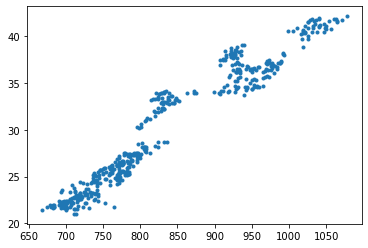

In [45]:
# we plot GOOG AAPL and fitted line
import matplotlib.pyplot as plt
plt.plot(df["GOOG"], df["AAPL"], '.')

In [46]:
hedgeRatio

0.05743167386586053

In [47]:
df.ratio.describe()

count    503.000000
mean       0.035704
std        0.003396
min        0.028407
25%        0.032465
50%        0.034727
75%        0.038881
max        0.042075
Name: ratio, dtype: float64

In [39]:
num_shares_google = 15
google_price = df.iloc[0, 0]
google_size = num_shares_google * google_price
r = 0.0009

aapl_price = df.iloc[0, 1]
num_shares_aapl = np.around(-google_size/aapl_price) 
aapl_size = aapl_price * num_shares_aapl
initial_leverage = google_price

google_size, aapl_size, initial_leverage


(11127.600402832031, -11117.24232673645, 741.8400268554688)

In [40]:
delta_t = 1 / (2*252)
equity = [100000]

leverage = [initial_leverage]
profits = [0]
previous_googl = df.iloc[0, 0]
previous_aapl = df.iloc[0, 1]
one_lege_size = 25000

In [41]:
hedgeRatio

0.05743167386586053